In [1]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/mlpf/")
from sklearn.cluster import DBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# data = pd.read_pickle(
#     "/eos/user/m/mgarciam/datasets_mlpf/models_trained/all_energies_10_15/mlpf/mlpf_all_energies_hgcal_loss/showers_df_evaluation_all_E_notrackeri/0_0_None_pandora.pt"
# )

In [88]:
from src.utils.inference.pandas_helpers import open_hgcal, open_mlpf_dataframe
from src.utils.inference.inference_metrics import obtain_metrics
path_mlpf = "/eos/user/m/mgarciam/datasets_mlpf/models_trained/all_energies_10_15/mlpf/mlpf_all_energies_hgcal_v3/showers_df_evaluation/0_0_None.pt"
sd, matched = open_mlpf_dataframe(path_mlpf, False)
# dict_2 = obtain_metrics(sd, matched, pandora = True)

In [89]:
matched

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E
0,20.102903,17.282038,17.282036,17.282038,0.0,1.064432,18.395559
1,6.435593,3.837020,3.837020,3.837020,0.0,1.041414,3.995924
3,0.828854,0.702061,0.702061,0.702061,0.0,1.063919,0.746936
4,16.588047,12.319963,12.173173,12.173179,0.0,1.101825,13.412704
5,2.518303,1.749763,1.638507,1.478204,0.0,1.046883,1.715325
...,...,...,...,...,...,...,...
4,15.006781,12.705613,15.517960,12.543621,0.0,1.147854,17.812351
6,17.280266,16.902323,16.902323,16.902323,0.0,1.090425,18.430717
7,32.536407,27.958433,27.948183,27.948183,0.0,1.020403,28.518414
8,27.221575,24.121420,25.095472,24.121420,0.0,0.968122,24.295479


In [98]:
5e-2

0.05

In [96]:
bins = np.arange(0, 51, 2)
from src.utils.inference.inference_metrics import obtain_MPV_and_68
bins_plot_histogram = [0, 5, 10, 20]
bins_per_binned_E = np.arange(0, 40, 0.005)
mean = []
variance_om = []
mean_true_rec = []
variance_om_true_rec = []
energy_resolutions = []
energy_resolutions_reco = []
dic_histograms = {}
for i in range(len(bins) - 1):
    bin_i = bins[i]
    bin_i1 = bins[i + 1]
    
    mask_above = matched["true_showers_E"] <= bin_i1
    mask_below = matched["true_showers_E"] > bin_i
    mask_check = matched["pred_showers_E"] > 0
    mask = mask_below * mask_above * mask_check

    pred_e = matched.calibrated_E[mask]
    true_rec = matched.true_showers_E[mask]
    if np.sum(mask) > 0:  # if the bin is not empty
        e_over_rec = pred_e / true_rec
        if i in bins_plot_histogram:
            dic_histograms[str(i) + "reco"] = e_over_rec
        
        mean_predtored, variance_om_true_rec_ = obtain_MPV_and_68(
            e_over_rec, bins_per_binned_E
        )
        mean_predtored = np.mean(e_over_rec)
        variance_om_true_rec_ = np.var(e_over_rec) / mean_predtored
        mean_true_rec.append(mean_predtored)
        variance_om_true_rec.append(variance_om_true_rec_)
        energy_resolutions_reco.append((bin_i1 + bin_i) / 2)


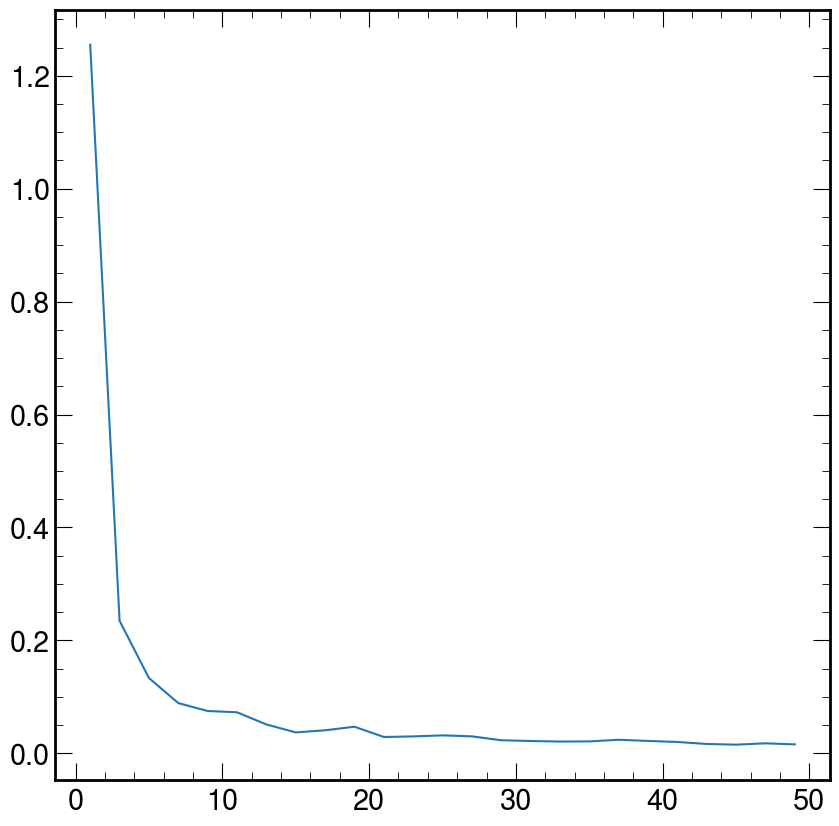

In [97]:
plt.plot(energy_resolutions_reco, variance_om_true_rec)


In [78]:
data_for_hist = e_over_rec
hist, bin_edges = np.histogram(data_for_hist, bins=bins_per_binned_E, density=True)
ind_max_hist = np.argmax(hist)
MPV = (bin_edges[ind_max_hist] + bin_edges[ind_max_hist + 1]) / 2
MPV


0.55

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 3.997e+01, 3.998e+01,
       3.999e+01])

(array([123., 133., 162., 241., 312., 388., 363., 356., 354., 331., 298.,
        289., 287., 250., 217., 202., 212., 187., 178., 165., 152., 137.,
        106., 109.,  93.,  92.,  87.,  78.,  93.,  69.,  62.,  64.,  79.,
         52.,  68.,  66.,  49.,  50.,  44.,  41.,  35.,  40.,  40.,  31.,
         36.,  25.,  30.,  34.,  23.,  21.,  22.,  25.,  29.,  20.,  19.,
         20.,  11.,  14.,  19.,  21.,  20.,  15.,  15.,  12.,  14.,  20.,
         18.,  13.,   8.,  12.,   3.,  14.,  10.,  13.,  11.,   7.,   7.,
          8.,  11.,  11.,  15.,   9.,  11.,   8.,   3.,   4.,   4.,   8.,
          5.,   6.,   5.,   5.,   6.,   7.,   7.,   5.,   5.,   6.,   8.,
          8.,   6.,   5.,   5.,   7.,   1.,   5.,   2.,   4.,   2.,   3.,
          5.,   2.,   0.,   0.,   1.,   5.,   1.,   1.,   5.,   1.,   9.,
          3.,   3.,   3.,   3.,   1.,   1.,   1.,   2.,   1.,   4.,   2.,
          1.,   3.,   0.,   2.,   2.,   4.,   0.,   3.,   0.,   0.,   3.,
          2.,   1.,   1.,   1.,   0., 

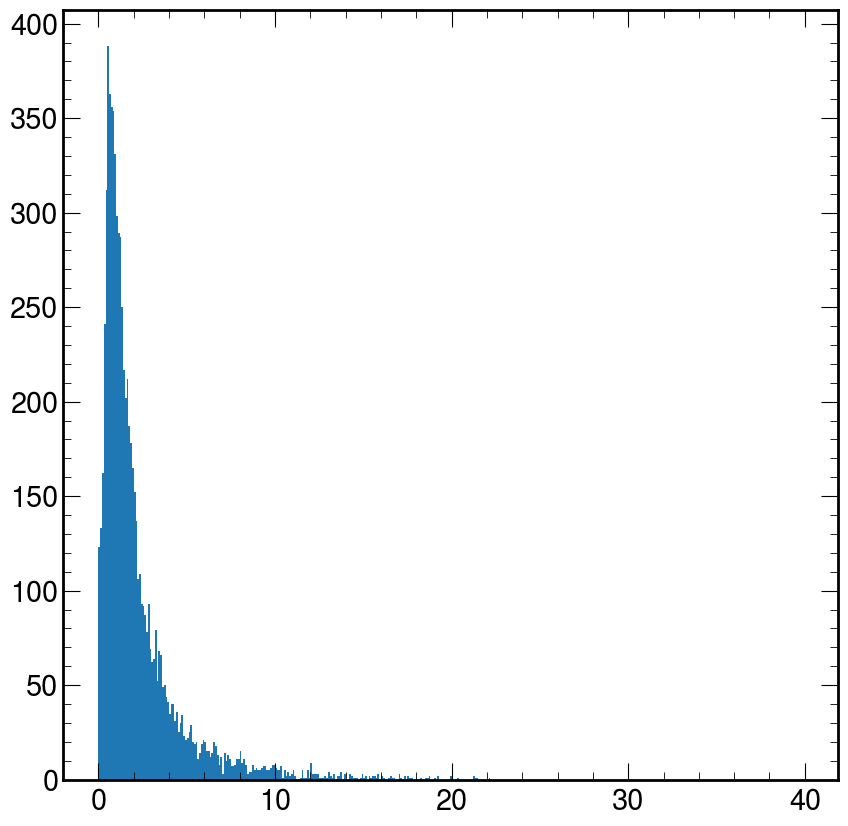

In [79]:
plt.hist(data_for_hist, bins=bins_per_binned_E, density=False)

<Axes: ylabel='Density'>

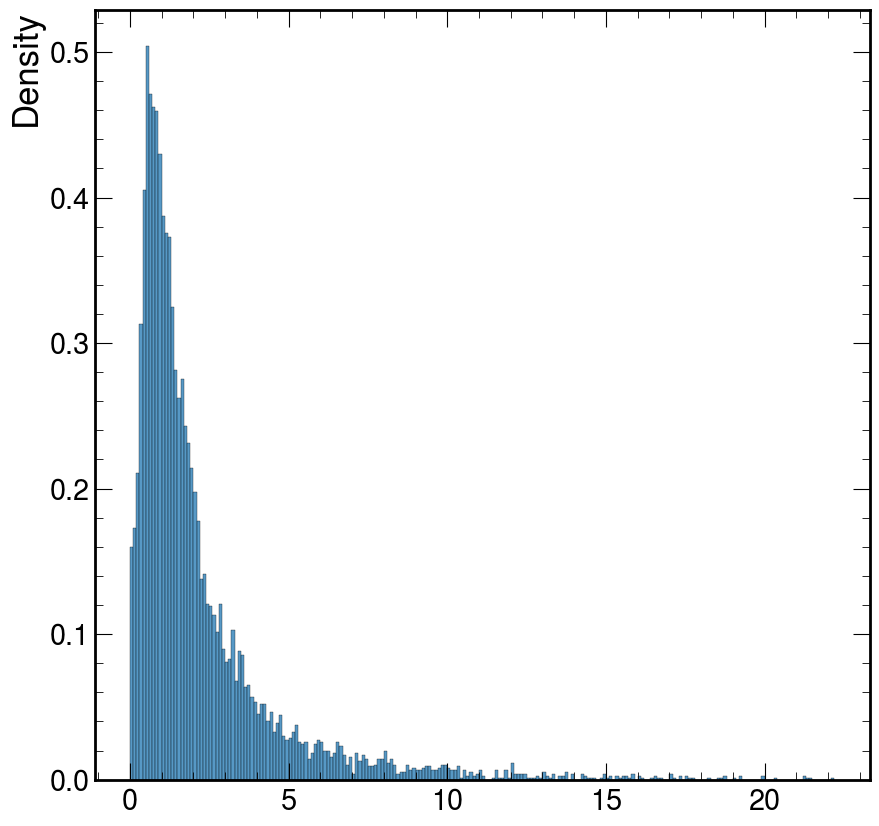

In [75]:
import seaborn as sns
plt.figure()
sns.histplot(data_for_hist, stat="density", binwidth = 0.1)


In [80]:
percentage = 0.683
theHist = hist
wmin = 0.2
wmax = 1.0
epsilon = 0.01

weight = 0.0
points = []
sums = []

# fill list of bin centers and the integral up to those point
for i in range(len(bin_edges) - 1):
    weight += theHist[i] * (bin_edges[i + 1] - bin_edges[i])
    points.append([(bin_edges[i + 1] + bin_edges[i]) / 2, weight])
    sums.append(weight)

low = wmin
high = wmax
width = 100
for i in range(len(points)):
    for j in range(i, len(points)):
        wy = points[j][1] - points[i][1]
        if abs(wy - percentage) < epsilon:
            wx = points[j][0] - points[i][0]
            if wx < width:
                low = points[i][0]
                high = points[j][0]
                width = wx
                ii = i
                jj = j
0.5 * (high - low), low, high

(1.05, 0.15000000000000002, 2.25)

array([0.000e+00, 1.000e-03, 2.000e-03, ..., 2.997e+00, 2.998e+00,
       2.999e+00])

In [ ]:
import seaborn as sns 
sns.histplot(data_for_hist, binwidth=0.001)

In [45]:
hist, bin_edges = np.histogram(values_, bins=bins_per_binned_E, density=True)

theHist = hist
percentage=0.683
# theHist, bin_edges = np.histogram(data_for_hist, bins=bins, density=True)
wmin = 0.2
wmax = 1.0
epsilon = 0.01

weight = 0.0
points = []
sums = []

# fill list of bin centers and the integral up to those point
for i in range(len(bin_edges) - 1):
    weight += theHist[i] * (bin_edges[i + 1] - bin_edges[i])
    points.append([(bin_edges[i + 1] + bin_edges[i]) / 2, weight])
    sums.append(weight)


low = wmin
high = wmax
width = 100
exp = []
for i in range(len(points)):
    for j in range(i, len(points)):
        wy = points[j][1] - points[i][1]
        exp.append(abs(wy - percentage))
        if abs(wy - percentage) < epsilon:
            print("here",abs(wy - percentage))
            wx = points[j][0] - points[i][0]
            if wx < width:
                low = points[i][0]
                high = points[j][0]
                width = wx
                ii = i
                jj = j

0.5 * (high - low), low, high

here 0.004561214495592436
here 0.0016229187071497009
here 0.00033594515181201157
here 0.0013153770812929233
here 0.0032742409402547468
here 0.006212536728697482
here 0.007499510284035171
here 0.0006434867776687891
here 0.0032742409402547468
here 0.009458374142996995
here 0.009150832517140106
here 0.0035817825661115243
here 0.0013153770812929233
here 0.0065200783545542595
here 0.0032742409402547468
here 0.004561214495592436
here 0.007191968658178283
here 0.0006434867776687891
here 0.0013153770812929233
here 0.0035817825661116354
here 0.009458374142996995
here 0.006212536728697371
here 0.00033594515181201157
here 0.004561214495592547
here 0.007499510284035282
here 0.009458374142997106
here 0.009458374142997106
here 0.005233104799216459
here 0.002294809010773724
here 0.00033594515181190054
here 0.00033594515181190054
here 0.0026023506366308347
here 0.004561214495592658
here 0.007499510284035393
here 0.008171400587659083
here 0.005233104799216348
here 0.002294809010773613
here 0.0003359451

(0.01100000000000001, 0.9815, 1.0035)

In [40]:
exp = np.array(exp)

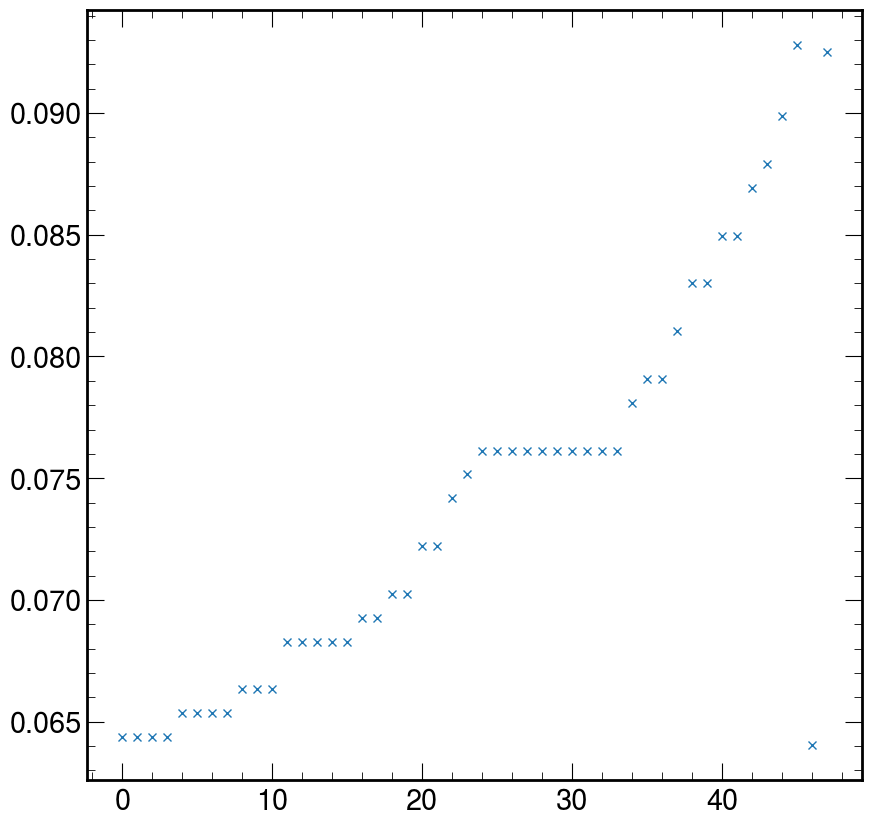

In [41]:
plt.plot(exp[exp<0.1], 'x')

In [42]:
0.683-0.065

0.6180000000000001

<Axes: ylabel='Count'>

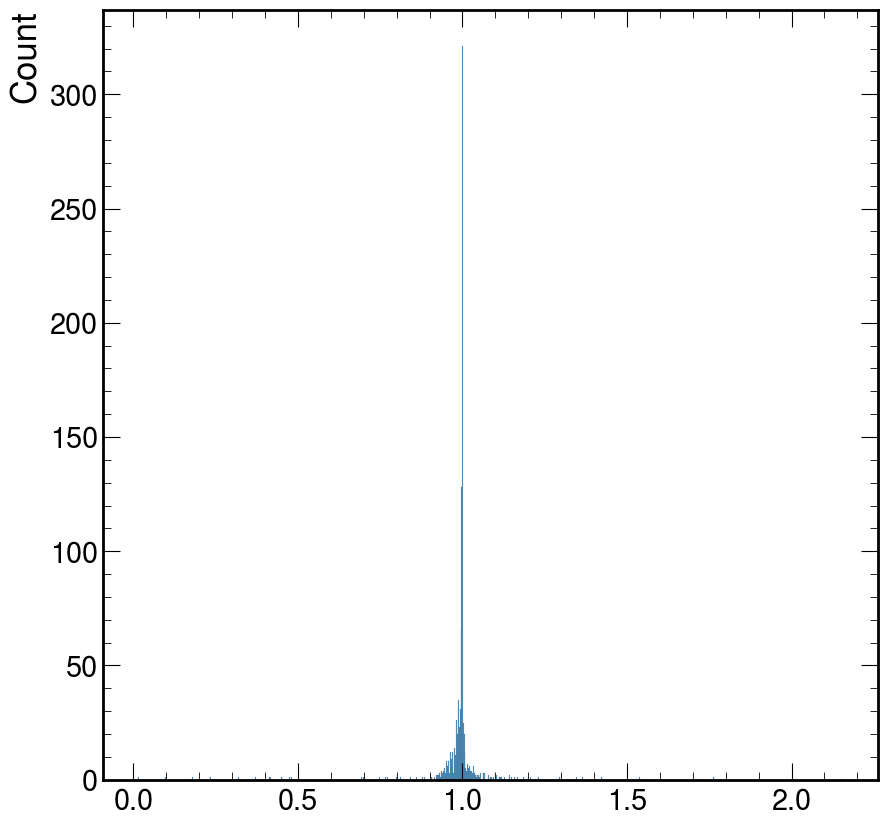

In [16]:
import seaborn as sns
sns.histplot(dict_2["dic_histograms"][str(10) + "reco"].values)

In [19]:
np.var(dict_2["dic_histograms"][str(10) + "reco"].values)/np.mean(dict_2["dic_histograms"][str(10) + "reco"].values)

0.011982665

In [29]:
a = torch.ones((3,1))*2
b = torch.ones((3,4))
print(a.shape, b.shape)
a*b

torch.Size([3, 1]) torch.Size([3, 4])


tensor([[2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.]])

In [6]:
if 12 % 10:
    print("in")

in


In [7]:
sd = data
bins = np.arange(0, 51, 2)
eff = []
fake_rate = []
energy_eff = []
for i in range(len(bins) - 1):
    bin_i = bins[i]
    bin_i1 = bins[i + 1]
    mask_above = sd.true_showers_E.values <= bin_i1
    mask_below = sd.true_showers_E.values > bin_i
    mask = mask_below * mask_above
    number_of_non_reconstructed_showers = np.sum(
        np.isnan(sd.pred_showers_E.values)[mask]
    )
    
    total_showers = len(sd.pred_showers_E.values[mask])
    print(i, np.sum(mask), number_of_non_reconstructed_showers, total_showers)
    if total_showers > 0:
        eff.append(
            (total_showers - number_of_non_reconstructed_showers) / total_showers
        )
        energy_eff.append((bin_i1 + bin_i) / 2)

0 14 14 14
1 9 8 9
2 3 1 3
3 2 0 2
4 2 1 2
5 1 0 1
6 0 0 0
7 2 0 2
8 3 0 3
9 2 1 2
10 1 0 1
11 2 0 2
12 0 0 0
13 1 0 1
14 2 0 2
15 0 0 0
16 0 0 0
17 0 0 0
18 0 0 0
19 1 0 1
20 0 0 0
21 0 0 0
22 0 0 0
23 1 0 1
24 1 0 1


In [8]:
eff

[0.0,
 0.1111111111111111,
 0.6666666666666666,
 1.0,
 0.5,
 1.0,
 1.0,
 1.0,
 0.5,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [2]:
dic = torch.load("/eos/user/m/mgarciam/datasets_mlpf/models_trained/mlpf_2309/evaluation_graphs/0_0_0.pt", map_location='cpu')

In [3]:
betas  = torch.sigmoid(dic["graph"].ndata["beta"])
X  = dic["graph"].ndata["coords"]
clustering_mode = "dbscan"
if clustering_mode == "clustering_normal":
    clustering = get_clustering(betas,X)
elif clustering_mode == "dbscan":
    distance_scale = torch.min(torch.abs(torch.min(X,dim=0)[0] - torch.max(X,dim=0)[0]))/20
    db = DBSCAN(eps=distance_scale, min_samples=100).fit(X)
    labels = db.labels_ +1
    labels = np.reshape(labels, (-1))
    labels = torch.Tensor(labels).long()

In [18]:
distance_scale.view(-1).numpy()[0]

0.13848315

In [4]:
from src.layers.inference_oc import obtain_intersection_matrix, obtain_union_matrix, plot_iou_matrix
particle_ids = torch.unique(dic["graph"].ndata['particle_number'])
shower_p_unique = torch.unique(labels)
e_hits = dic["graph"].ndata['e_hits'].view(-1)
i_m, i_m_w = obtain_intersection_matrix(shower_p_unique,particle_ids, labels, dic, e_hits)
u_m = obtain_union_matrix(shower_p_unique,particle_ids, labels, dic)
        


In [111]:
# fig, ax = plt.subplots()
# ax.matshow(intersection_matrix_w, cmap=plt.cm.Blues)
# for i in range(0,intersection_matrix_w.shape[1]):
#     for j in range(0,intersection_matrix_w.shape[0]):
#         c = np.round(intersection_matrix_w[j,i].numpy(),2)
#         ax.text(i, j, str(c), va='center', ha='center')

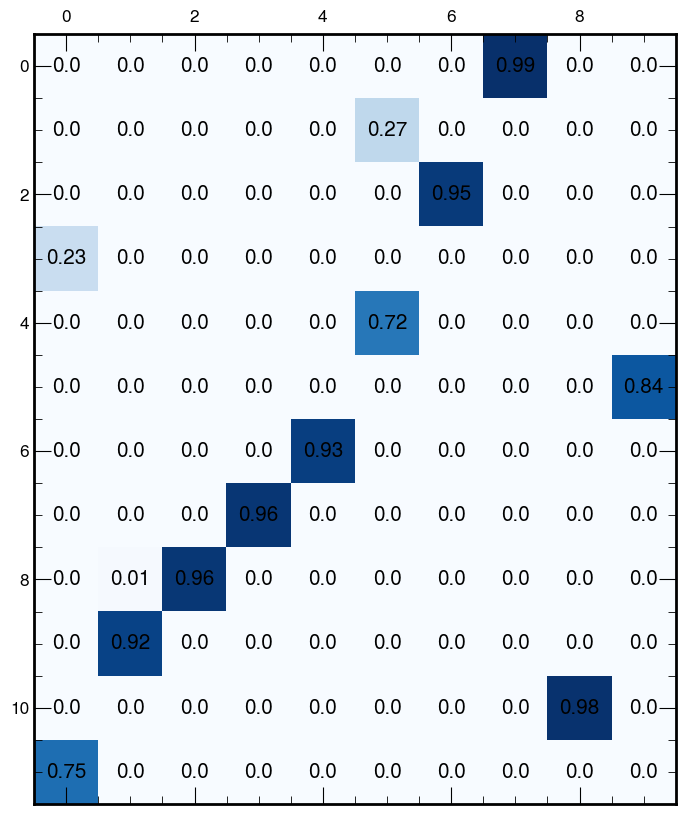

In [7]:
iou_matrix = i_m / u_m
row_ind, col_ind = linear_sum_assignment(-torch.transpose(iou_matrix[1:,:],1,0))
plot_iou_matrix(iou_matrix)


In [8]:
e_pred_showers = scatter_add(dic["graph"].ndata['e_hits'].view(-1), labels)

In [10]:
pred_showers = shower_p_unique
true_showers = particle_ids
max_num_showers = torch.max(torch.Tensor([len(pred_showers), len(true_showers)]))

# Add true showers (matched and unmatched)
energy_t = dic["part_true"][:,3]
index_matches = col_ind+1
matched_es = torch.zeros_like(energy_t)*torch.nan
matched_es[row_ind] = e_pred_showers[index_matches]
intersection_E = torch.zeros_like(energy_t)*torch.nan
ie_e = obtain_intersection_values(i_m_w,row_ind, col_ind )
intersection_E[row_ind] = ie_e
## showers that are not in the true showers:
pred_showers[index_matches] = -1
mask = pred_showers != -1
fake_showers_e = e_pred_showers[mask]
fake_showers_showers_e_truw  = torch.zeros((fake_showers_e.shape[0]))*torch.nan
energy_t = torch.cat((energy_t, fake_showers_showers_e_truw), dim=0)
e_pred = torch.cat((matched_es,fake_showers_e),dim=0) 
e_pred_t = torch.cat((intersection_E, torch.zeros_like(fake_showers_e)*torch.nan), dim=0)
d = {'true_showers_E': energy_t, 'pred_showers_E':e_pred, 'e_pred_and_truth':e_pred_t}
df = pd.DataFrame(data=d)


In [11]:
# from this we can get:
# efficiency
# fake rate
# mean to reco and corrected variance 

pd.concat([df,df])

,true_showers_E,pred_showers_E,e_pred_and_truth
0,38.533840,33.902077,33.902077
1,38.755615,NaN,NaN
2,35.598511,32.292294,32.220055
3,31.861416,NaN,NaN
4,46.738140,74.239151,37.669594
5,22.605057,16.590586,16.590586
6,33.303520,30.185093,30.185093
7,47.177418,40.744930,40.744930
8,33.549385,27.776760,27.697741
9,22.423925,15.094002,14.484302


In [18]:
np.sum(~np.isnan(df["pred_showers_E"].values))/len(df["pred_showers_E"].values)

0.8461538461538461

In [143]:

showers = []
energy_hits = dic["graph"].ndata["e_hits"].view(-1)
scatter_add(energy_hits, torch.Tensor(labels).long())


tensor([103.0073,  25.8023,  96.7578,  17.4388,  39.5602,  25.7076])

In [84]:
scatter_add(energy_hits, dic["graph"].ndata['particle_number'].long())

tensor([ 0.0000, 28.2123, 35.8559, 29.2372, 27.5849, 43.5459, 25.0361, 21.6893,
        17.3787, 29.9355, 24.0694, 18.6286, 42.6165, 48.7015])

In [144]:
from src.logger.plotting_tools import shuffle_truth_colors
tidx = dic["graph"].ndata['particle_number']
features =  dic["graph"].ndata["e_hits"]
data = {
            "X": X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
df["orig_tIdx"] = df["tIdx"]
rdst = np.random.RandomState(1234567890)  # all the same
shuffle_truth_colors(df, "tIdx", rdst)

# hover_data = ["orig_tIdx", "idx"] + [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
# hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [145]:
from src.logger.plotting_tools import shuffle_truth_colors
tidx = np.reshape(labels, (-1,1))
features =  dic["graph"].ndata["e_hits"]
data = {
            "X": X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx,
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
df["orig_tIdx"] = df["tIdx"]
rdst = np.random.RandomState(1234567890)  # all the same
shuffle_truth_colors(df, "tIdx", rdst)

# hover_data = ["orig_tIdx", "idx"] + [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
# hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))